In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from tqdm import tqdm
import time


def magnitud(Flux):
    try:
        return 27.5-2.5*np.log10(np.abs(Flux))
    except RuntimeWarning:
        return 27.5-2.5*np.log10(np.abs(Flux)+1e-8)

def magnitud_err(Flux,Flux_err):
    top = Flux + Flux_err
    bot = Flux - Flux_err
    top_mag = magnitud(top)
    bot_mag = magnitud(bot)
    return np.abs(top_mag-bot_mag)

train_frac = 0.7
Bands =["u", "i", "g", "r", "z", "Y"]
class_folders=['ELASTICC_TRAIN_uLens-Single_PyLIMA', 'ELASTICC_TRAIN_Mdwarf-flare', 'ELASTICC_TRAIN_EB','ELASTICC_TRAIN_RRL']
now = time.localtime()
now = time.strftime("%y%m%d%H%M", now)
folder_classes_path = "Elasticc"

class_folders = [folder for folder in os.listdir("Elasticc") if folder.startswith("ELASTICC")]
# Calculate the class (folder) with min amount of light curves
n_lc={}
for folder in class_folders:
    folder=folder_classes_path+"/"+folder
    filenames_HEAD = sorted([file for file in os.listdir(folder) if '_HEAD.FITS' in file])
    n = []
    for head in filenames_HEAD:
        with fits.open(folder+"/"+head) as hdu:
            n.append(len(hdu[1].data))
    n_lc[folder]=sum(n)
n_max = min(n_lc.values())
print(n_max)

2091


(0.0, 230000.0)

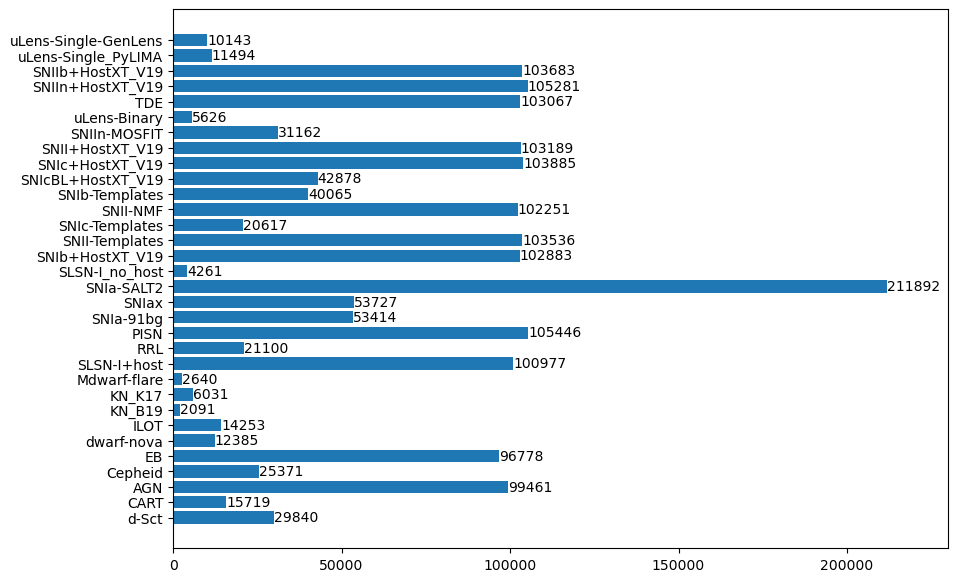

In [37]:
# for i in n_lc:
#     print("{:<20}:{:>8}".format(i[24:],n_lc[i]))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,7))
keys = [key[24:] for key in n_lc.keys()]
bar = ax.barh(keys, n_lc.values())
ax.bar_label(bar)
ax.set_xlim(0,230000)
# ax.set_xticklabels(keys, rotation=45, ha='right')

In [3]:
%%time
n_train = int(n_max*train_frac)
n_test = n_max - n_train
n_bands = len(bands)
for b in Bands:
    run_name = str(now+b)
    training_path = run_name+"/"+f"training_set-{now}"
    test_path = run_name+"/"+f"test_set-{now}"
    try:
        os.mkdir(run_name)
    except FileExistsError:
        pass
    try:
        os.mkdir(training_path)
        os.mkdir(test_path)
    except FileExistsError:
        pass
    for j, folder in enumerate(class_folders):    # Folders of each class
        filenames_PHOT = sorted([file for file in os.listdir(folder_classes_path+"/"+folder) if '_PHOT.FITS' in file])
        filenames_HEAD = sorted([file for file in os.listdir(folder_classes_path+"/"+folder) if '_HEAD.FITS' in file])
        class_files = list(zip(filenames_HEAD, filenames_PHOT))
        print("--------------------------------------------------------------------")
        print(f"Folder: {folder}    {j+1}/{len(class_folders)}")
        try:
            os.mkdir(training_path+"/"+folder)
        except FileExistsError:
            pass
        try:
            os.mkdir(test_path+"/"+folder)
        except FileExistsError:
            pass
        for i, (head, phot) in enumerate(class_files):    # .fit files of each simulation
            if len(os.listdir(test_path+"/"+folder))/n_bands >= n_test:
                break
            print(f"Fits file: {head[-15:-13]}    {i+1}/{len(class_files)}")
            lc_phot = fits.open(folder_classes_path+"/"+folder+"/"+phot)[1].data
            lc_head = fits.open(folder_classes_path+"/"+folder+"/"+head)[1].data
            set_path = training_path
            cambio = False
            for j, lc in enumerate(tqdm(lc_head)):      # Light curves of each .fits
                inicio = lc[10]
                final = lc[11]
                snid = lc[0]
                lc_band = lc_phot[inicio:final]
                if int(len(os.listdir(test_path+"/"+folder))/n_bands) >= n_test:
                    train_size = int(len(os.listdir(training_path+"/"+folder))/n_bands)
                    test_size = int(len(os.listdir(test_path+"/"+folder))/n_bands)
                    print(f"Test set: {test_size} light curves from {folder}")
                    print(f"Training set: {train_size} light curves from {folder}")
                    break
                if int(len(os.listdir(training_path+"/"+folder))/n_bands) >= n_train and cambio == False:
                    set_path = test_path
                    cambio = True
                lc_band = lc_band[lc_band.BAND == b]
                Mjd     = lc_band.MJD
                if Mjd == []:
                    continue
                Flux    = lc_band.FLUXCAL
                Mag     = magnitud(Flux) 
                Fluxerr = lc_band.FLUXCALERR
                Magerr = magnitud_err(Flux,Fluxerr)
                with open(set_path+"/"+folder+"/"+folder.split("/")[-1][15:]+ '_' + snid + b +'.dat', 'w') as f:
                    for mjd, mag, magerr in zip(Mjd, Mag, Magerr) :
                        f.write(str('   '+"%.3f" %mjd)+'  '+str("%.4f" %mag)+'   '+str("%.3f" %magerr)+'\n')
                    f.write('\n')

--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


100%|██████████| 290/290 [00:08<00:00, 33.93it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 29.55it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 25.79it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.69it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:13<00:00, 21.29it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:14<00:00, 19.10it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:12<00:00, 23.93it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:09<00:00, 31.01it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 25.83it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 23.80it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 34.69it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 33.55it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 31.94it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:02<00:00, 31.49it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 30.49it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 30.00it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 30.61it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 28.11it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 28.33it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 27.16it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 26.93it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 26.26it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:02<00:00, 25.79it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 24.15it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:02<00:00, 24.33it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 23.31it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.37it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 23.13it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 21.86it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 21.22it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 20.22it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 19.72it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 19.77it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.06it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 18.48it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 18.68it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 18.61it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 18.25it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 19.86it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 36.44it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 35.30it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:01<00:00, 33.46it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 33.11it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 30.85it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 29.75it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 29.63it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 27.14it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:03<00:00, 26.24it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 25.32it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 24.45it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:37<00:00, 24.96it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:27, 25.08it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 31.80it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.55it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.83it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.65it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:18<00:00, 27.73it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:24, 21.53it/s]


Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


 44%|████▍     | 129/290 [00:03<00:04, 33.28it/s]/tmp/ipykernel_25748/4228778112.py:11: RuntimeWarning: divide by zero encountered in log10
  return 27.5-2.5*np.log10(np.abs(Flux))
100%|██████████| 290/290 [00:08<00:00, 34.25it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 29.55it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 26.22it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.08it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:13<00:00, 21.20it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:14<00:00, 19.01it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:13<00:00, 23.69it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:09<00:00, 30.53it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 26.20it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 23.35it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 34.84it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 33.28it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 33.25it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:02<00:00, 31.85it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 31.28it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 30.17it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 29.17it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 28.68it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 27.70it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 26.49it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 25.45it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 25.22it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:03<00:00, 24.49it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 23.49it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:03<00:00, 23.57it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 22.56it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.34it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 22.35it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 21.88it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 21.11it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 21.43it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 20.52it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 19.81it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.18it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 18.31it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 18.74it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 18.83it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 17.88it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 19.56it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 35.36it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 33.29it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:02<00:00, 32.20it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 31.48it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 30.60it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 28.97it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 27.84it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 25.57it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:03<00:00, 25.08it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 25.05it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 24.77it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:37<00:00, 25.00it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:29, 24.66it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 31.64it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.85it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.82it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.78it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:19<00:00, 27.39it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:25, 20.46it/s]


Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


100%|██████████| 290/290 [00:08<00:00, 33.84it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 30.08it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 26.60it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.40it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:13<00:00, 21.29it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:14<00:00, 19.41it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:13<00:00, 23.60it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:09<00:00, 30.94it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 26.45it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 24.93it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 35.74it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 35.57it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 34.37it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:01<00:00, 34.19it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 32.05it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 30.82it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 29.78it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 30.61it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 28.29it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 27.48it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 25.25it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 24.71it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:02<00:00, 25.09it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 23.61it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:03<00:00, 23.26it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 23.79it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.49it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 22.89it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 21.47it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 21.17it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 20.64it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 20.29it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 20.25it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.38it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 18.77it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 19.00it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 18.28it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 17.86it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 19.86it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 36.16it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 34.39it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:01<00:00, 32.95it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 31.66it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 30.28it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 28.53it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 28.36it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 28.78it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:03<00:00, 26.65it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 25.84it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 25.14it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:36<00:00, 25.34it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:27, 25.22it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 32.58it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.60it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.64it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.54it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:19<00:00, 27.25it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:24, 21.13it/s]


Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


100%|██████████| 290/290 [00:08<00:00, 33.62it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 28.94it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 25.54it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.09it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:13<00:00, 20.84it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:14<00:00, 19.07it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:13<00:00, 23.53it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:09<00:00, 30.63it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 26.39it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 23.36it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 34.99it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 34.33it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 32.44it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:02<00:00, 31.66it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 31.32it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 29.48it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 29.24it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 28.94it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 27.44it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 25.89it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 25.19it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 25.06it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:02<00:00, 25.31it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 23.21it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:03<00:00, 19.20it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 22.94it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.33it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 22.33it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 21.81it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 20.74it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 20.03it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 19.97it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 19.64it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.09it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 18.80it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 17.27it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 17.53it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 17.27it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 18.85it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 33.27it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 31.87it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:02<00:00, 32.15it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 30.91it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 29.66it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 28.49it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 26.43it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 25.45it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:02<00:00, 26.68it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 26.53it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 24.94it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:37<00:00, 24.89it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:29, 24.74it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 31.89it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.68it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.60it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.50it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:18<00:00, 27.88it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:26, 19.85it/s]


Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


100%|██████████| 290/290 [00:08<00:00, 33.84it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 28.43it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 25.84it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.06it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:16<00:00, 17.85it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:16<00:00, 16.53it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:13<00:00, 23.32it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:09<00:00, 31.01it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 26.11it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 24.42it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 36.28it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 34.75it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 33.21it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:02<00:00, 31.71it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 31.72it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 30.12it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 27.96it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 29.74it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 27.66it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 26.85it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 25.72it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 25.25it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 25.79it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:02<00:00, 23.75it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 24.06it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.62it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 22.68it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 22.12it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 21.76it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 20.41it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 20.48it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 20.48it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.62it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 19.39it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 18.63it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 18.54it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 18.25it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 20.03it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 34.01it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 32.91it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:01<00:00, 32.74it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 31.86it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 30.99it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 29.62it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 28.96it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 26.34it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:03<00:00, 25.82it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 25.16it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 25.17it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:37<00:00, 24.95it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:27, 25.27it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 32.35it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.67it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.76it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.37it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:18<00:00, 27.46it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:24, 21.06it/s]


Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_uLens-Single_PyLIMA    1/4
Fits file: 01    1/40


100%|██████████| 290/290 [00:08<00:00, 34.21it/s]


Fits file: 02    2/40


100%|██████████| 275/275 [00:09<00:00, 29.63it/s]


Fits file: 03    3/40


100%|██████████| 270/270 [00:10<00:00, 26.04it/s]


Fits file: 04    4/40


100%|██████████| 289/289 [00:12<00:00, 23.59it/s]


Fits file: 05    5/40


100%|██████████| 289/289 [00:13<00:00, 21.13it/s]


Fits file: 06    6/40


100%|██████████| 279/279 [00:14<00:00, 19.09it/s]


Fits file: 07    7/40


100%|██████████| 310/310 [00:13<00:00, 23.76it/s]


Fits file: 08    8/40


100%|██████████| 287/287 [00:12<00:00, 23.20it/s]


Fits file: 09    9/40


100%|██████████| 297/297 [00:11<00:00, 26.37it/s]


Fits file: 10    10/40


 18%|█▊        | 54/307 [00:02<00:10, 25.18it/s]


Test set: 793 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
Training set: 1847 light curves from ELASTICC_TRAIN_uLens-Single_PyLIMA
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_Mdwarf-flare    2/4
Fits file: 01    1/40


100%|██████████| 58/58 [00:01<00:00, 36.40it/s]


Fits file: 02    2/40


100%|██████████| 61/61 [00:01<00:00, 34.54it/s]


Fits file: 03    3/40


100%|██████████| 59/59 [00:01<00:00, 34.01it/s]


Fits file: 04    4/40


100%|██████████| 65/65 [00:01<00:00, 34.00it/s]


Fits file: 05    5/40


100%|██████████| 72/72 [00:02<00:00, 32.50it/s]


Fits file: 06    6/40


100%|██████████| 67/67 [00:02<00:00, 30.94it/s]


Fits file: 07    7/40


100%|██████████| 54/54 [00:01<00:00, 29.98it/s]


Fits file: 08    8/40


100%|██████████| 63/63 [00:02<00:00, 29.14it/s]


Fits file: 09    9/40


100%|██████████| 72/72 [00:02<00:00, 28.17it/s]


Fits file: 10    10/40


100%|██████████| 84/84 [00:03<00:00, 27.50it/s]


Fits file: 11    11/40


100%|██████████| 46/46 [00:01<00:00, 27.04it/s]


Fits file: 12    12/40


100%|██████████| 49/49 [00:01<00:00, 25.42it/s]


Fits file: 13    13/40


100%|██████████| 75/75 [00:03<00:00, 24.86it/s]


Fits file: 14    14/40


100%|██████████| 69/69 [00:02<00:00, 25.31it/s]


Fits file: 15    15/40


100%|██████████| 71/71 [00:02<00:00, 24.23it/s]


Fits file: 16    16/40


100%|██████████| 66/66 [00:02<00:00, 23.60it/s]


Fits file: 17    17/40


100%|██████████| 48/48 [00:02<00:00, 22.84it/s]


Fits file: 18    18/40


100%|██████████| 57/57 [00:02<00:00, 22.48it/s]


Fits file: 19    19/40


100%|██████████| 91/91 [00:04<00:00, 21.90it/s]


Fits file: 20    20/40


100%|██████████| 55/55 [00:02<00:00, 21.86it/s]


Fits file: 21    21/40


100%|██████████| 69/69 [00:03<00:00, 21.14it/s]


Fits file: 22    22/40


100%|██████████| 66/66 [00:03<00:00, 20.48it/s]


Fits file: 23    23/40


100%|██████████| 68/68 [00:03<00:00, 20.52it/s]


Fits file: 24    24/40


100%|██████████| 66/66 [00:03<00:00, 19.71it/s]


Fits file: 25    25/40


100%|██████████| 65/65 [00:03<00:00, 19.51it/s]


Fits file: 26    26/40


100%|██████████| 63/63 [00:03<00:00, 18.80it/s]


Fits file: 27    27/40


100%|██████████| 60/60 [00:03<00:00, 18.12it/s]


Fits file: 28    28/40


100%|██████████| 69/69 [00:03<00:00, 17.76it/s]


Fits file: 29    29/40


100%|██████████| 53/53 [00:02<00:00, 19.85it/s]


Fits file: 30    30/40


100%|██████████| 82/82 [00:02<00:00, 35.82it/s]


Fits file: 31    31/40


100%|██████████| 55/55 [00:01<00:00, 34.46it/s]


Fits file: 32    32/40


100%|██████████| 65/65 [00:01<00:00, 33.06it/s]


Fits file: 33    33/40


100%|██████████| 77/77 [00:02<00:00, 32.06it/s]


Fits file: 34    34/40


100%|██████████| 71/71 [00:02<00:00, 30.05it/s]


Fits file: 35    35/40


100%|██████████| 68/68 [00:02<00:00, 28.69it/s]


Fits file: 36    36/40


100%|██████████| 70/70 [00:02<00:00, 27.69it/s]


Fits file: 37    37/40


100%|██████████| 67/67 [00:02<00:00, 28.27it/s]


Fits file: 38    38/40


100%|██████████| 80/80 [00:03<00:00, 25.72it/s]


Fits file: 39    39/40


100%|██████████| 68/68 [00:02<00:00, 25.80it/s]


Fits file: 40    40/40


100%|██████████| 76/76 [00:03<00:00, 24.82it/s]


--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_EB    3/4
Fits file: 01    1/40


100%|██████████| 2434/2434 [01:36<00:00, 25.19it/s]


Fits file: 02    2/40


  9%|▊         | 206/2410 [00:08<01:26, 25.34it/s]


Test set: 793 light curves from ELASTICC_TRAIN_EB
Training set: 1847 light curves from ELASTICC_TRAIN_EB
--------------------------------------------------------------------
Folder: ELASTICC_TRAIN_RRL    4/4
Fits file: 01    1/40


100%|██████████| 525/525 [00:16<00:00, 31.79it/s]


Fits file: 02    2/40


100%|██████████| 527/527 [00:21<00:00, 24.94it/s]


Fits file: 03    3/40


100%|██████████| 528/528 [00:25<00:00, 20.96it/s]


Fits file: 04    4/40


100%|██████████| 532/532 [00:22<00:00, 23.65it/s]


Fits file: 05    5/40


100%|██████████| 521/521 [00:19<00:00, 27.19it/s]


Fits file: 06    6/40


  1%|▏         | 7/526 [00:00<00:23, 21.87it/s]

Test set: 793 light curves from ELASTICC_TRAIN_RRL
Training set: 1847 light curves from ELASTICC_TRAIN_RRL
CPU times: user 14min 28s, sys: 2min 10s, total: 16min 39s
Wall time: 43min 7s


In [3]:
import os
n_train = len(os.listdir(training_path+"/"+folder))
n_test = len(os.listdir(test_path+"/"+folder))
print(f"Training set size: {n_train}")
print(f"Test set size: {n_test}")

Training set size: 1847
Test set size: 793
